<a href="https://colab.research.google.com/github/shwbak/HAI-Anomaly-Detection/blob/main/AutoEncoder%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_Anomaly_Detection_DWT%26_DT_CWT_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SSH 키 발급

In [ ]:
!ssh-keygen

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): ^C


In [ ]:
%cd ~/.ssh/

[Errno 2] No such file or directory: '/root/.ssh/'
/content


In [ ]:
! cat id_rsa.pub

cat: id_rsa.pub: No such file or directory


# Git 연동 확인

In [ ]:
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

/bin/bash: /root/.ssh/known_hosts: No such file or directory


In [ ]:
!ssh -T git@github.com

Host key verification failed.


#구글드라이브 마운트

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Github Origin을 Pull

In [54]:
from os.path import join
from os import makedirs

PROJ_path = "/content/drive/MyDrive/Colab Notebooks/"
%cd "{PROJ_path}"
try:
  makedirs("HAI-Anomaly-Detection")
  REPO_path = "/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/"
  %cd "{REPO_path}"
  !git init
  !git config --global user.email "minseok4864@ajou.ac.kr"
  !git config --global user.name "minseok4864"
  !git remote add origin https://github.com/shwbak/HAI-Anomaly-Detection

  !pip install --upgrade git-lfs

  !git lfs install
  !git lfs track "*.csv"
  !git add .gitattributes
except:
  print("동일한 이름의 폴더가 이미 존재합니다.")

/content/drive/MyDrive/Colab Notebooks
동일한 이름의 폴더가 이미 존재합니다.


Pull 코드

In [55]:
REPO_path = "/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/"
%cd "{REPO_path}"

!pip install --upgrade git-lfs

!git init
!git config --global user.email "minseok4864@ajou.ac.kr"
!git config --global user.name "minseok4864"
!git pull origin main

/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reinitialized existing Git repository in /content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/.git/
From https://github.com/shwbak/HAI-Anomaly-Detection
 * branch            main       -> FETCH_HEAD
Already up to date.


#소스코드

In [56]:
REPO_path = "/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/"
%cd "{REPO_path}"
!pip install eTaPR-21.8.2-py3-none-any.whl

/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./eTaPR-21.8.2-py3-none-any.whl
eTaPR is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def plot_history(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x', label="loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

In [58]:
import torch.nn as nn

device = get_default_device()


class Autoencoder(nn.Module):
    def __init__(self, in_size, latent_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_size, int(in_size/2)),
            nn.ReLU(True),
            nn.Linear(int(in_size/2), int(in_size/4)),
            nn.ReLU(True),
            nn.Linear(int(in_size/4), latent_size),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, int(in_size/4)),
            nn.ReLU(True),
            nn.Linear(int(in_size/4), int(in_size/2)),
            nn.ReLU(True),
            nn.Linear(int(in_size/2), in_size),
            nn.Sigmoid()
        )
  
    def training_step(self, batch, epoch):
        z = self.encoder(batch)
        out = self.decoder(z)
        loss1 = nn.MSELoss()(out, batch)
        loss2 = nn.L1Loss()(out, batch)
        return loss1, loss2

    def validation_step(self, batch, epoch):
        z = self.encoder(batch)
        out = self.decoder(z)
        loss = nn.MSELoss()(out, batch)
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))


def evaluate(model, val_loader, epoch):
    outputs = [model.validation_step(to_device(batch, device), epoch) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.AdamW):
    history = []
    optimizer = opt_func(list(model.encoder.parameters()) + list(model.decoder.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch = to_device(batch, device)
            loss1, loss2 = model.training_step(batch, epoch+1)
            loss1.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader, epoch + 1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def testing(model, test_loader):
    results = []
    for [batch] in test_loader:
        batch = to_device(batch, device)
        z = model.encoder(batch)
        reconstructed = model.decoder(z)
        results.append(torch.mean((batch - reconstructed)**2, axis=1))
    return results

In [59]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr
from tqdm import tqdm

In [60]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [61]:
TRAIN_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/HAICon2021_dataset/train/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/HAICon2021_dataset/test/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/HAICon2021_dataset/validation/").glob("*.csv")])

In [62]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_01 = dataframe_from_csv(TRAIN_DATASET[0])
TRAIN_DF_RAW_01.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_02 = dataframe_from_csv(TRAIN_DATASET[1])
TRAIN_DF_RAW_02.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_03 = dataframe_from_csv(TRAIN_DATASET[2])
TRAIN_DF_RAW_03.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_04 = dataframe_from_csv(TRAIN_DATASET[3])
TRAIN_DF_RAW_04.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_05 = dataframe_from_csv(TRAIN_DATASET[4])
TRAIN_DF_RAW_05.reset_index(drop=True,inplace=True)

TRAIN_DF_RAW_06 = dataframe_from_csv(TRAIN_DATASET[5])
TRAIN_DF_RAW_06.reset_index(drop=True,inplace=True)

print(TRAIN_DF_RAW.shape)
TRAIN_DF_RAW.head()

(1004402, 87)


,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503


아래 두 목록에는 중복된 장치들이 있으니 이 점 유의하시면 좋을 것 같습니다.

변화가 없는 장치 목록
- C22, C52, C63, C82, C85, C55, C36, C26, C49, C38, C39, C29, C18, C19, C09

범주형 데이터 형태인 장치 목록
- C02, C07, C08, C09, C10, C17, C18, C19, C22, C26, C29, C34, C35, C36, C38, C39, C46, C48, C49, C52, C55, C58, C61, C63, C64, C69, C79, C82, C85

예측의 Loss 값이 튀는 경우를 없애주기 위해서 범주형 데이터의 경우 제외시켜주었습니다.

하지만 유의미한 결과를 보지는 못했던 것 같습니다.

In [63]:
TIMESTAMP_FIELD = "timestamp"
DROP_FIELD = ["C02", "C07", "C08", "C09", "C10", "C17", "C18", "C19", "C22", "C26", "C29", "C34", "C35", "C36", "C38", "C39", "C46", "C48", "C49", "C52", "C55", "C58", "C61", "C63", "C64", "C69", "C79", "C82", "C85"]
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW_01.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET = VALID_COLUMNS_IN_TRAIN_DATASET.drop(DROP_FIELD)
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C03', 'C04', 'C05', 'C06', 'C11', 'C12', 'C13', 'C14', 'C15',
       'C16', 'C20', 'C21', 'C23', 'C24', 'C25', 'C27', 'C28', 'C30', 'C31',
       'C32', 'C33', 'C37', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C47',
       'C50', 'C51', 'C53', 'C54', 'C56', 'C57', 'C59', 'C60', 'C62', 'C65',
       'C66', 'C67', 'C68', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76',
       'C77', 'C78', 'C80', 'C81', 'C83', 'C84', 'C86'],
      dtype='object')

In [64]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [65]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [66]:
TRAIN_DF_01 = normalize(TRAIN_DF_RAW_01[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [67]:
TRAIN_DF_02 = normalize(TRAIN_DF_RAW_02[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_03 = normalize(TRAIN_DF_RAW_03[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_04 = normalize(TRAIN_DF_RAW_04[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_05 = normalize(TRAIN_DF_RAW_05[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF_06 = normalize(TRAIN_DF_RAW_06[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

#DT-CWT

In [68]:
!pip install dtcwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


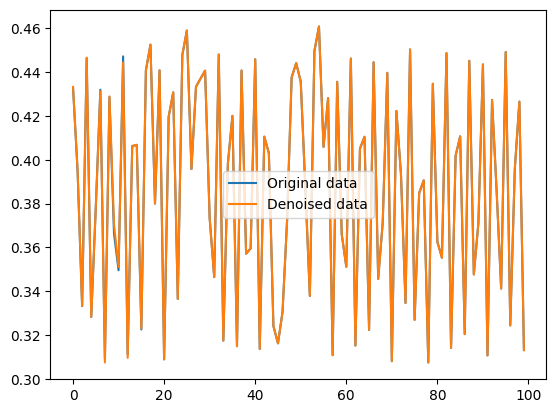

In [49]:
import numpy as np
import dtcwt
import matplotlib.pyplot as plt

def denoise_dtcwt(signal):
    # Create a DTCWT object
    transform = dtcwt.Transform1d()

    # Perform the forward transform
    transformed = transform.forward(signal)

    # Thresholding on the high-pass coefficients
    threshold = 0.01 # Adjust the threshold value as needed
    thresholded_highpasses = []
    for hp in transformed.highpasses:
        thresholded_hp = np.where(np.abs(hp) < threshold, 0, hp)
        thresholded_highpasses.append(thresholded_hp)

    # Create a new Pyramid object with the thresholded high-pass coefficients
    denoised_coeffs = dtcwt.Pyramid(transformed.lowpass, thresholded_highpasses)

    # Reconstruct the denoised signal using inverse DTCWT
    denoised = transform.inverse(denoised_coeffs)

    return denoised

# Original data
origin_Data = TRAIN_DF_01['C01'][:100].values

# Denoise using DTCWT
denoised_data = denoise_dtcwt(origin_Data)

# Plotting
plt.plot(origin_Data, label='Original data')
plt.plot(denoised_data, label='Denoised data')
plt.legend()
plt.show()

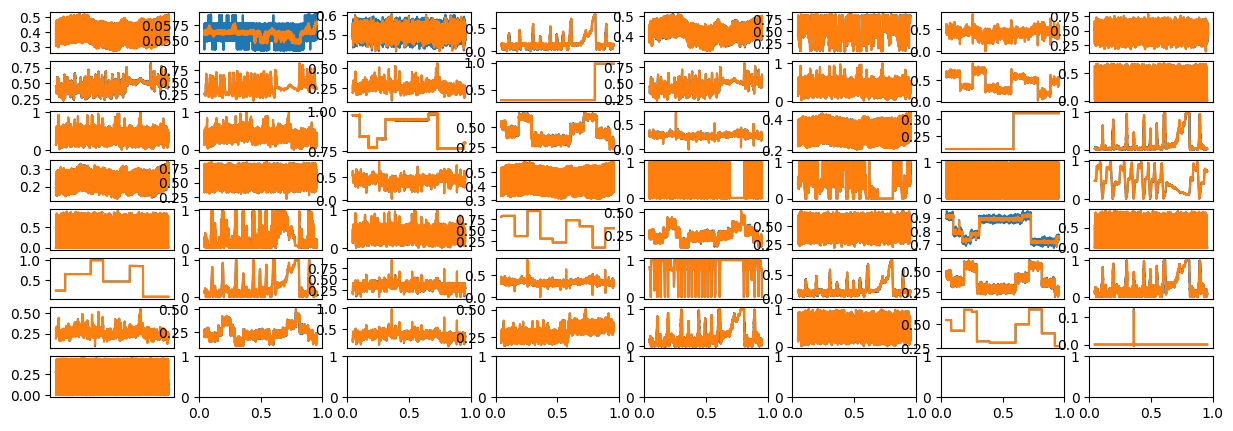

TRAIN_DF_01:
            C01       C03       C04       C05       C06       C11       C12  \
0      0.394957  0.056398  0.512092  0.145630  0.424153  0.491294  0.557254   
1      0.394957  0.056398  0.512092  0.145630  0.424153  0.491294  0.557254   
2      0.394957  0.056398  0.512092  0.145630  0.424153  0.491294  0.557254   
3      0.394957  0.056398  0.512092  0.145630  0.424153  0.491294  0.557254   
4      0.394957  0.056398  0.512092  0.145630  0.424153  0.491294  0.557254   
...         ...       ...       ...       ...       ...       ...       ...   
93596  0.437224  0.057214  0.511205  0.135655  0.456856  0.795983  0.444091   
93597  0.437224  0.057214  0.511205  0.135655  0.456856  0.795983  0.444091   
93598  0.437224  0.057214  0.511205  0.135655  0.456856  0.795983  0.444091   
93599  0.437224  0.057214  0.511205  0.135655  0.456856  0.795983  0.444091   
93600  0.437224  0.057214  0.511205  0.135655  0.456856  0.795983  0.444091   

            C13       C14       C15  .

In [107]:
import numpy as np
import dtcwt
import matplotlib.pyplot as plt

def denoise_dtcwt(signal):
    if len(signal) % 2 != 0:
        signal = signal[:-1] 
    # Create a DTCWT object
    transform = dtcwt.Transform1d()

    # Perform the forward transform
    transformed = transform.forward(signal)

    # Thresholding on the high-pass coefficients
    threshold = 0.03 # Adjust the threshold value as needed
    thresholded_highpasses = []
    for hp in transformed.highpasses:
        thresholded_hp = np.where(np.abs(hp) < threshold, 0, hp)
        thresholded_highpasses.append(thresholded_hp)

    # Create a new Pyramid object with the thresholded high-pass coefficients
    denoised_coeffs = dtcwt.Pyramid(transformed.lowpass, thresholded_highpasses)

    # Reconstruct the denoised signal using inverse DTCWT
    denoised = transform.inverse(denoised_coeffs)

    return denoised

def dataframe_DN(df):
  temp = pd.DataFrame(df.iloc[:-1, :])

  for colnam in VALID_COLUMNS_IN_TRAIN_DATASET:
    temp[colnam] = denoise_dtcwt(df[colnam])
    #temp[colnam] = denoise_wavelet(df[colnam], method='VisuShrink', wavelet_levels=3, sigma=0.1)    
  return temp

TRAIN_DF_01_DN = dataframe_DN(TRAIN_DF_01)

fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(15, 5))

for i, c in enumerate(VALID_COLUMNS_IN_TRAIN_DATASET):
  k = i // 8
  j = i % 8
  axs[k, j].plot(TRAIN_DF_01[c], label='Original data')
  axs[k, j].plot(TRAIN_DF_01_DN[c], label='Denoised data')
  axs[k, j].xaxis.set_visible(False)

plt.show()

print("TRAIN_DF_01:")
print(TRAIN_DF_01)
print("Length:", len(TRAIN_DF_01))

#노이즈 제거 데모 코드 (DWT)


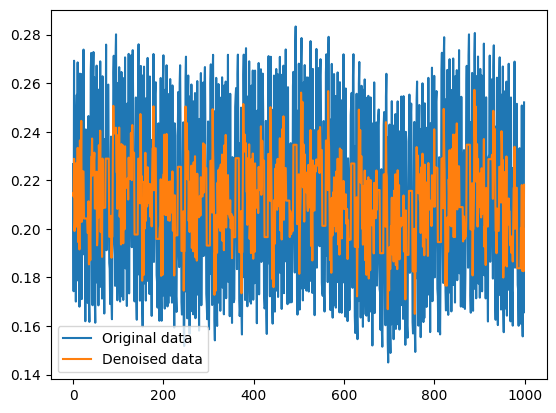

In [104]:
from skimage.restoration import denoise_wavelet

origin_Data = TRAIN_DF_01['C41'][:1000]
TRAIN_DF_01_C01_DN = denoise_wavelet(origin_Data, method='BayesShrink', sigma=0.03)

plt.plot(origin_Data, label='Original data')
plt.plot(TRAIN_DF_01_C01_DN, label='Denoised data')
plt.legend()
plt.show()

#노이즈 제거 (DWT)

In [80]:
from skimage.restoration import denoise_wavelet

def dataframe_DN(df):
  temp = pd.DataFrame(df)

  for colnam in VALID_COLUMNS_IN_TRAIN_DATASET:
    temp[colnam] = denoise_wavelet(df[colnam], method='BayesShrink',  sigma=0.1)
    #temp[colnam] = denoise_wavelet(df[colnam], method='VisuShrink', wavelet_levels=3, sigma=0.1)    
  return temp

In [81]:
TRAIN_DF_01_DN = dataframe_DN(TRAIN_DF_01)

/usr/local/lib/python3.10/dist-packages/pywt/_thresholding.py:23: RuntimeWarning: overflow encountered in true_divide
  thresholded = (1 - value/magnitude)


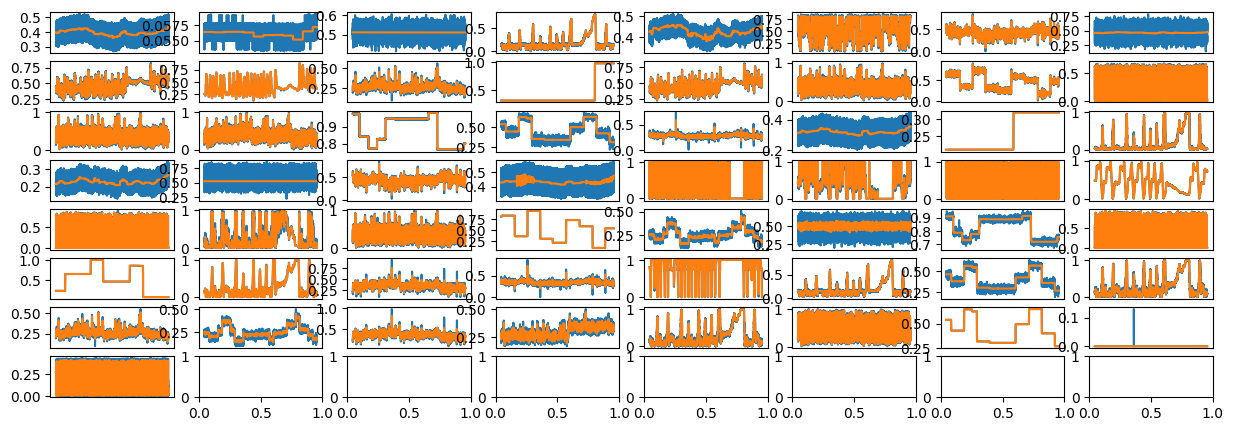

TRAIN_DF_01:
            C01       C03       C04       C05       C06       C11       C12  \
0      0.394957  0.056398  0.512092  0.145630  0.424153  0.491294  0.557254   
1      0.394957  0.056398  0.512092  0.145630  0.424153  0.491294  0.557254   
2      0.394957  0.056398  0.512092  0.145630  0.424153  0.491294  0.557254   
3      0.394957  0.056398  0.512092  0.145630  0.424153  0.491294  0.557254   
4      0.394957  0.056398  0.512092  0.145630  0.424153  0.491294  0.557254   
...         ...       ...       ...       ...       ...       ...       ...   
93596  0.437224  0.057214  0.511205  0.135655  0.456856  0.795983  0.444091   
93597  0.437224  0.057214  0.511205  0.135655  0.456856  0.795983  0.444091   
93598  0.437224  0.057214  0.511205  0.135655  0.456856  0.795983  0.444091   
93599  0.437224  0.057214  0.511205  0.135655  0.456856  0.795983  0.444091   
93600  0.437224  0.057214  0.511205  0.135655  0.456856  0.795983  0.444091   

            C13       C14       C15  .

In [82]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(15, 5))

for i, c in enumerate(VALID_COLUMNS_IN_TRAIN_DATASET):
  k = i // 8
  j = i % 8
  axs[k, j].plot(TRAIN_DF_01[c], label='Original data')
  axs[k, j].plot(TRAIN_DF_01_DN[c], label='Denoised data')
  axs[k, j].xaxis.set_visible(False)

plt.show()


In [ ]:
TRAIN_DF_02_DN = dataframe_DN(TRAIN_DF_02)
TRAIN_DF_03_DN = dataframe_DN(TRAIN_DF_03)
TRAIN_DF_04_DN = dataframe_DN(TRAIN_DF_04)
TRAIN_DF_05_DN = dataframe_DN(TRAIN_DF_05)
TRAIN_DF_06_DN = dataframe_DN(TRAIN_DF_06)

In [ ]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [ ]:
window_size=12

windows_normal_01 = TRAIN_DF_01_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_01.shape[0]-window_size)[:, None]]

In [ ]:
#windows_normal_02 = TRAIN_DF_02_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_02.shape[0]-window_size)[:, None]]
#windows_normal_03 = TRAIN_DF_03_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_03.shape[0]-window_size)[:, None]]
windows_normal_04 = TRAIN_DF_04_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_04.shape[0]-window_size)[:, None]]
windows_normal_05 = TRAIN_DF_05_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_05.shape[0]-window_size)[:, None]]
windows_normal_06 = TRAIN_DF_06_DN.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_06.shape[0]-window_size)[:, None]]

In [ ]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal_01.shape[1]*windows_normal_01.shape[2]
z_size=windows_normal_01.shape[1]*hidden_size

In [ ]:
train_loader_01 = data_utils.TensorDataset(torch.from_numpy(windows_normal_01).float().view(([windows_normal_01.shape[0],w_size])))
#train_loader_02 = data_utils.TensorDataset(torch.from_numpy(windows_normal_02).float().view(([windows_normal_02.shape[0],w_size])))
#train_loader_03 = data_utils.TensorDataset(torch.from_numpy(windows_normal_03).float().view(([windows_normal_03.shape[0],w_size])))
train_loader_04 = data_utils.TensorDataset(torch.from_numpy(windows_normal_04).float().view(([windows_normal_04.shape[0],w_size])))
train_loader_05 = data_utils.TensorDataset(torch.from_numpy(windows_normal_05).float().view(([windows_normal_05.shape[0],w_size])))

val_loader_01 = data_utils.TensorDataset(torch.from_numpy(windows_normal_06).float().view(([windows_normal_06.shape[0],w_size])))

train_loader = torch.utils.data.DataLoader(data_utils.ConcatDataset(
    [train_loader_01, train_loader_04, train_loader_05]
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(val_loader_01, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
model = Autoencoder(w_size, z_size)
model = to_device(model,device)

In [ ]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=684, out_features=342, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=342, out_features=171, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=171, out_features=1200, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1200, out_features=171, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=171, out_features=342, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=342, out_features=684, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss: 0.0356
Epoch [1], val_loss: 0.0308
Epoch [2], val_loss: 0.0263
Epoch [3], val_loss: 0.0248
Epoch [4], val_loss: 0.0244
Epoch [5], val_loss: 0.0241
Epoch [6], val_loss: 0.0241
Epoch [7], val_loss: 0.0238
Epoch [8], val_loss: 0.0237
Epoch [9], val_loss: 0.0235
Epoch [10], val_loss: 0.0220
Epoch [11], val_loss: 0.0179
Epoch [12], val_loss: 0.0181
Epoch [13], val_loss: 0.0169
Epoch [14], val_loss: 0.0164
Epoch [15], val_loss: 0.0162
Epoch [16], val_loss: 0.0162
Epoch [17], val_loss: 0.0160
Epoch [18], val_loss: 0.0160
Epoch [19], val_loss: 0.0167
Epoch [20], val_loss: 0.0160
Epoch [21], val_loss: 0.0159
Epoch [22], val_loss: 0.0157
Epoch [23], val_loss: 0.0158
Epoch [24], val_loss: 0.0156
Epoch [25], val_loss: 0.0155
Epoch [26], val_loss: 0.0156
Epoch [27], val_loss: 0.0141
Epoch [28], val_loss: 0.0140
Epoch [29], val_loss: 0.0145
Epoch [30], val_loss: 0.0140
Epoch [31], val_loss: 0.0144
Epoch [32], val_loss: 0.0139
Epoch [33], val_loss: 0.0144
Epoch [34], val_loss: 0.

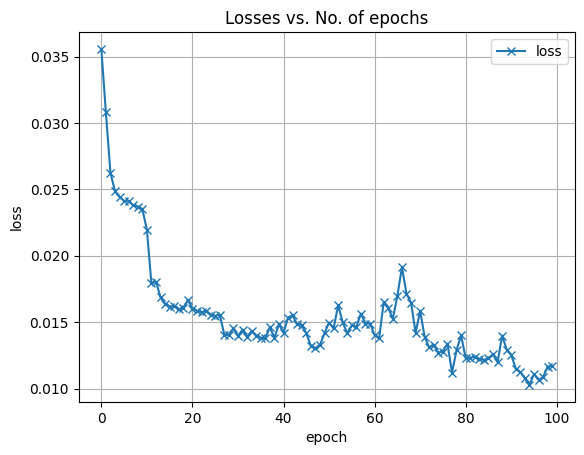

In [ ]:
plot_history(history)

In [ ]:
from os.path import join
from os import makedirs

%cd "{REPO_path}"
try:
  makedirs("models")
except:
  print("동일한 이름의 폴더가 이미 존재합니다.")

/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection
동일한 이름의 폴더가 이미 존재합니다.


In [ ]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder': model.decoder.state_dict()
            }, "./models/usad.pth")

In [ ]:
checkpoint = torch.load("./models/usad.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder.load_state_dict(checkpoint['decoder'])

<All keys matched successfully>

In [ ]:
VALIDATION_DF_RAW = dataframe_from_csv(VALIDATION_DATASET[0])
VALIDATION_DF_RAW.reset_index(drop=True,inplace=True)

In [ ]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

다양한 모델을 사용하였습니다만, Train Set을 기준으로 Min-Max Normalize를 진행한 뒤, Validation Set과 Test Set에 대해 Train Dataset의 Min값 혹은 Max값을 넘어가는 값에 x2, x1.5를 해주었을 경우 성능이 소폭 향상되는 모습을 보여주었습니다.

Min-Max Normalization이 어느정도 Anomaly Detection에서 효과를 보여준다는 걸 보여주는 것으로도 볼 수 있고, 값이 튀는 장치들에 실제로도 보안위협이 들어왔다고 생각할 수도 있을 것 같습니다.

In [ ]:
for i in tqdm(range(VALIDATION_DF.shape[0])):
    for j in range(VALIDATION_DF.shape[1]):
        if VALIDATION_DF.iloc[i, j] < 0:
            VALIDATION_DF.iloc[i, j] = VALIDATION_DF.iloc[i, j] * 2
        elif VALIDATION_DF.iloc[i, j] > 1:
            VALIDATION_DF.iloc[i, j] = VALIDATION_DF.iloc[i, j] * 2

100%|██████████| 86400/86400 [03:11<00:00, 450.61it/s]


In [ ]:
val = VALIDATION_DF.values[np.arange(window_size)[None, :] + np.arange(VALIDATION_DF.shape[0]-window_size)[:, None]]

In [ ]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(val).float().view(([val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
results = testing(model,test_loader)

In [ ]:
labels = [int(label!= 0 ) for label in VALIDATION_DF_RAW["attack"].values]

In [ ]:
y_pred = np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [ ]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = np.max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * np.array(peak) * np.array(0.3))
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

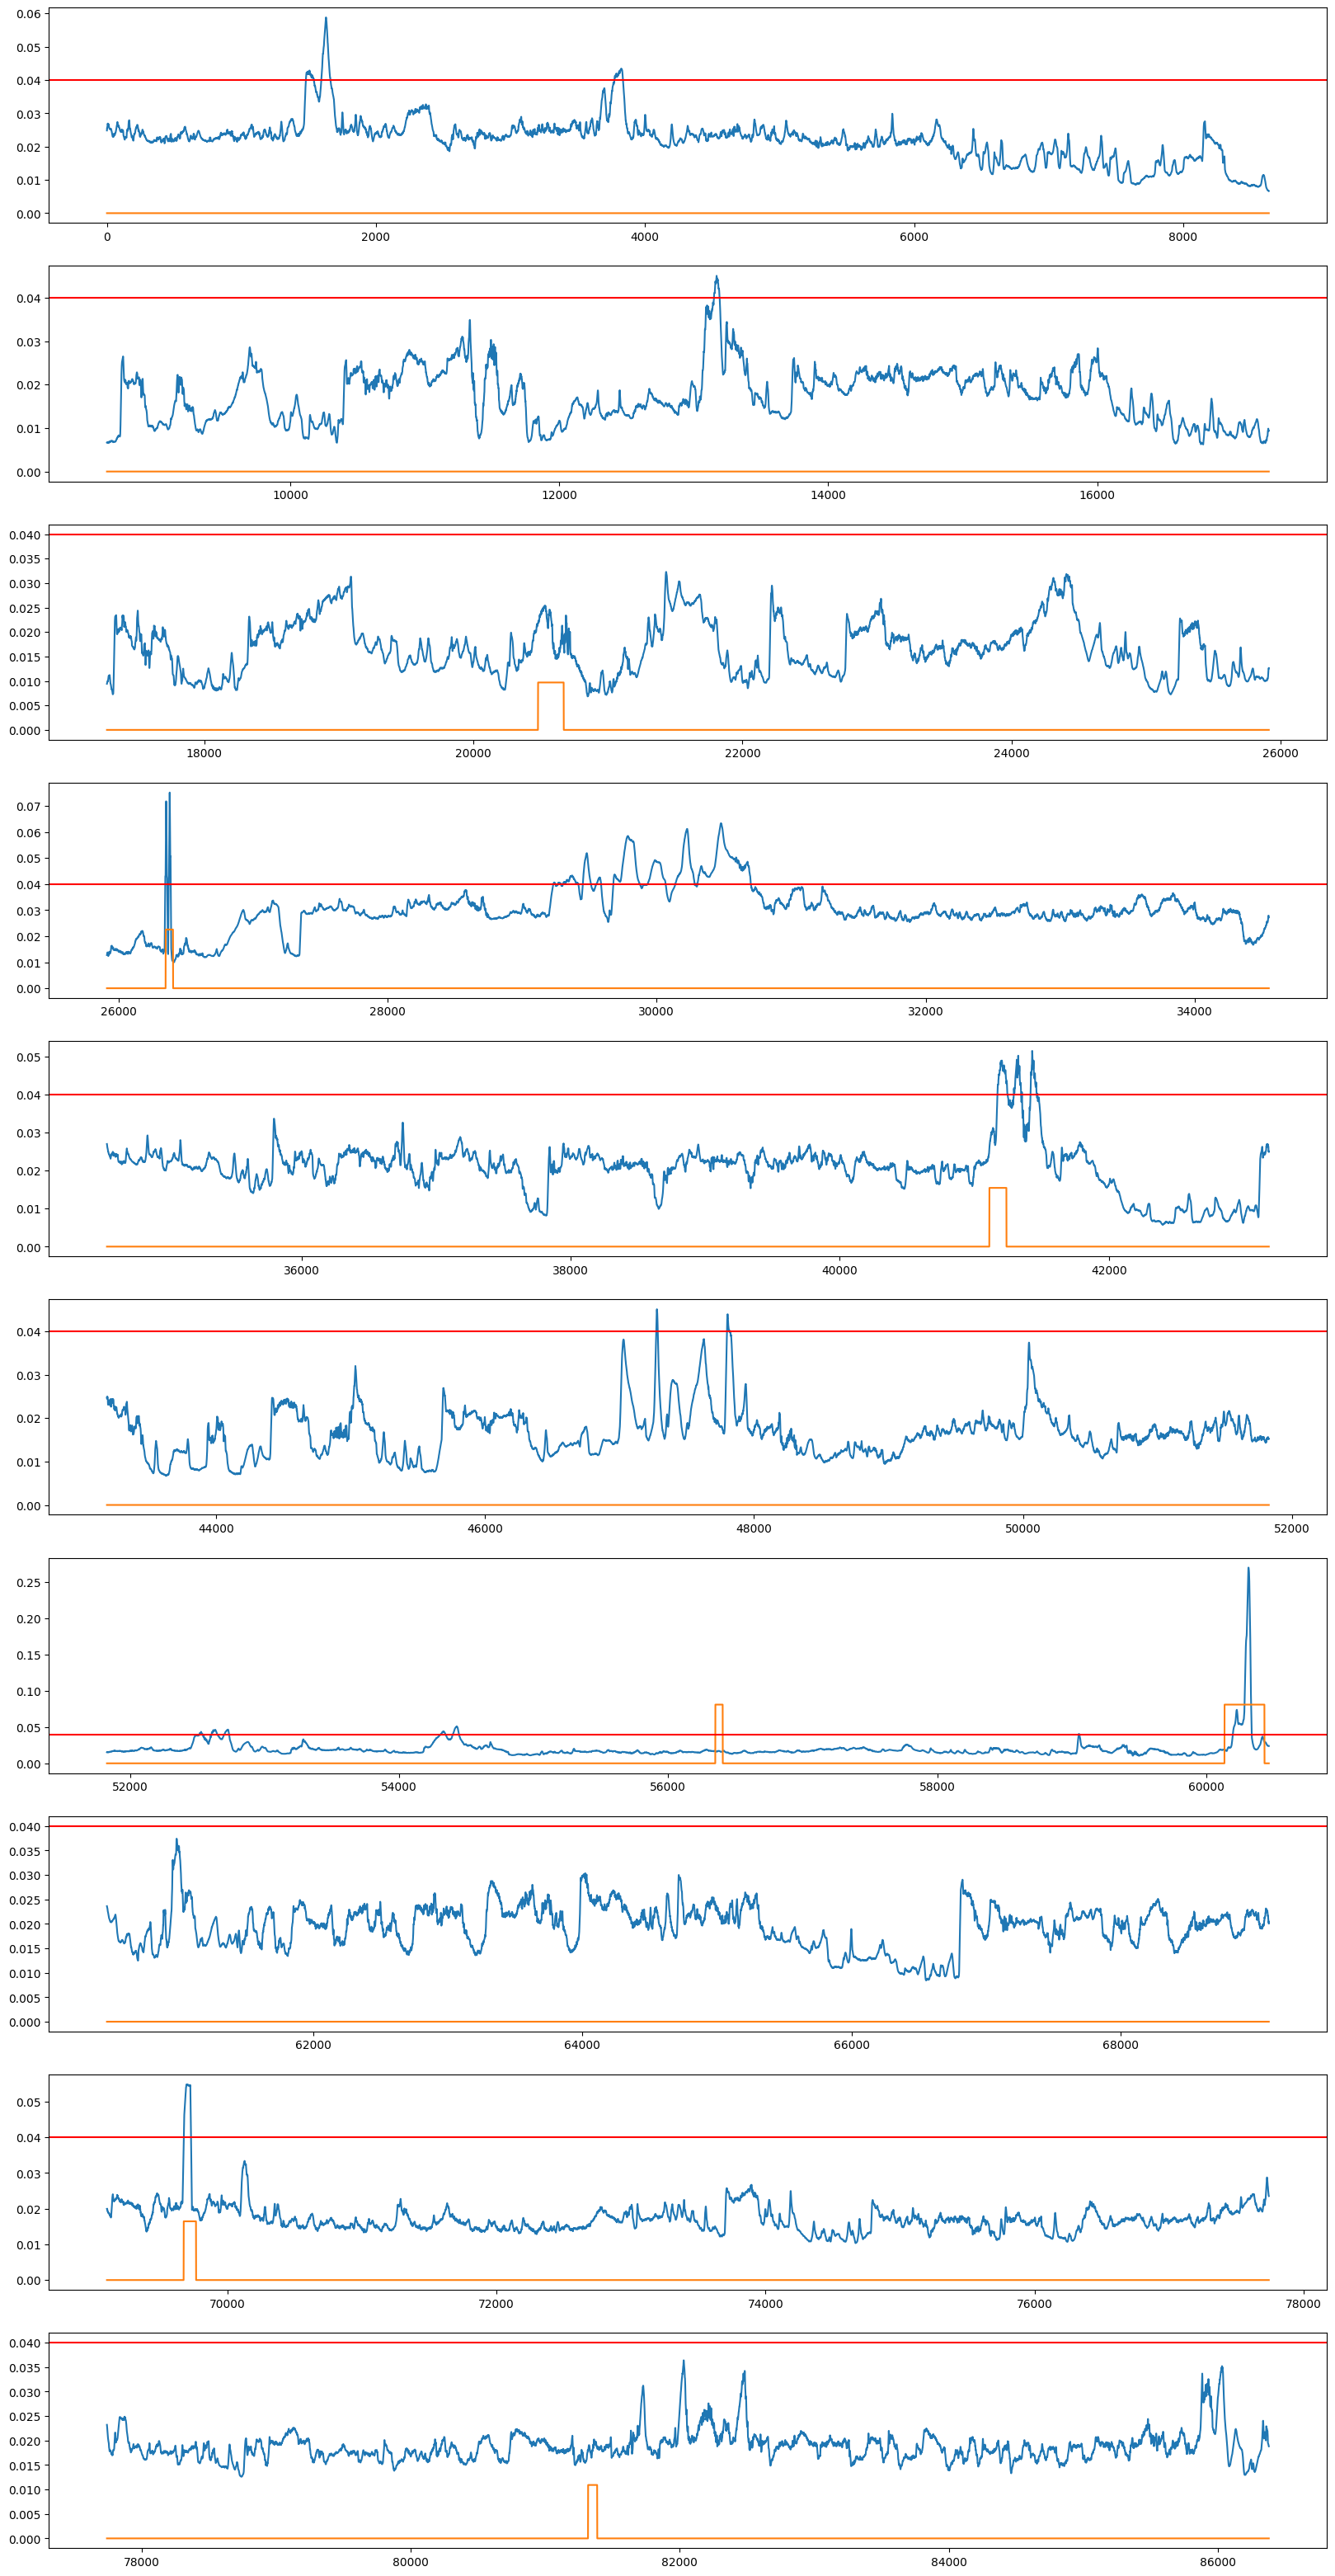

In [ ]:
THRESHOLD = 0.04
check_graph(y_pred, labels, piece=10, THRESHOLD=THRESHOLD)

In [ ]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [ ]:
LABELS = put_labels(y_pred, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (86388,))

In [ ]:
a = np.zeros(window_size)
LABELS = np.append(a, LABELS, axis=0)

In [ ]:
TaPR = etapr.evaluate_haicon(anomalies=labels, predictions=LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.151 (TaP: 0.095, TaR: 0.369)
# of detected anomalies: 4
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7efd0fca8cd0>, <TaPR_pkg.DataManage.Range.Range object at 0x7efd0fca8be0>, <TaPR_pkg.DataManage.Range.Range object at 0x7efd0fca9210>, <TaPR_pkg.DataManage.Range.Range object at 0x7efd0fca9900>]
